In [1]:
# Install required packages
!pip install rouge-score transformers torch sentencepiece nltk sacrebleu bert-score nltk -q

print("✅ All packages installed successfully!")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.9 MB/s eta 0:00:00:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 6.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━

In [2]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import glob
from rouge_score import rouge_scorer
from transformers import AutoTokenizer, AutoModel
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import sent_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("✅ All imports successful!")


✅ All imports successful!


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 Using device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


🔧 Using device: cuda
   GPU: Tesla T4
   Memory: 15.83 GB


In [4]:
class UnsupervisedLegalDataset(Dataset):
    """Dataset for unsupervised RL - no reference summaries needed"""
    def __init__(self, judgment_dir):
        self.aspects = ['facts', 'analysis', 'argument', 'judgement', 'statute']
        self.judgment_files = sorted(glob.glob(os.path.join(judgment_dir, '*.txt')))
        
        print(f"📁 Found {len(self.judgment_files)} judgments")
        
        self.data = []
        for jf in self.judgment_files:
            with open(jf, 'r', encoding='utf-8', errors='ignore') as f:
                judgment = f.read().strip()
            
            if judgment and len(judgment.split()) > 50:
                self.data.append({
                    'judgment': judgment,
                    'judgment_file': os.path.basename(jf)
                })
        
        print(f"\n📊 Total valid samples loaded: {len(self.data)}")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]


In [5]:
judgment_path = '/kaggle/input/summaries/IN-Ext/judgement'

dataset = UnsupervisedLegalDataset(judgment_path)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size]
)

print(f"\n📈 Dataset Split:")
print(f"   Training: {len(train_dataset)} samples ({len(train_dataset)/len(dataset)*100:.1f}%)")
print(f"   Validation: {len(val_dataset)} samples ({len(val_dataset)/len(dataset)*100:.1f}%)")


📁 Found 50 judgments

📊 Total valid samples loaded: 50

📈 Dataset Split:
   Training: 40 samples (80.0%)
   Validation: 10 samples (20.0%)


In [6]:
class SentenceEncoder(nn.Module):
    def __init__(self, model_name='law-ai/InLegalBERT', hidden_dim=768):
        super(SentenceEncoder, self).__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.hidden_dim = hidden_dim
        
        # Freeze encoder
        for param in self.model.parameters():
            param.requires_grad = False
    
    def mean_pooling(self, model_output, attention_mask):
        token_embeddings = model_output[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    
    def forward(self, sentences):
        encoded = self.tokenizer(sentences, padding=True, truncation=True, 
                                max_length=128, return_tensors='pt')
        encoded = {k: v.to(device) for k, v in encoded.items()}
        
        with torch.no_grad():
            model_output = self.model(**encoded)
        
        embeddings = self.mean_pooling(model_output, encoded['attention_mask'])
        return embeddings

print("✅ Sentence Encoder defined")


✅ Sentence Encoder defined


In [7]:
class MultiAspectPolicyNetwork(nn.Module):
    def __init__(self, input_dim=384, hidden_dim=256, num_aspects=5, dropout=0.5):
        super(MultiAspectPolicyNetwork, self).__init__()
        
        self.num_aspects = num_aspects
        self.aspects = ['facts', 'analysis', 'argument', 'judgement', 'statute']
        self.hidden_dim = hidden_dim
        
        # Shared LSTM encoder
        self.shared_lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, 
                                   bidirectional=True, batch_first=True, dropout=dropout)
        
        # Position and aspect embeddings
        self.position_embedding = nn.Embedding(500, 64)
        self.aspect_embedding = nn.Embedding(num_aspects, hidden_dim * 2)
        
        # Attention mechanism
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_dim * 2,
            num_heads=4, 
            dropout=dropout,
            batch_first=True
        )
        
        # Aspect-specific heads
        self.aspect_heads = nn.ModuleDict()
        for aspect in self.aspects:
            self.aspect_heads[aspect] = nn.Sequential(
                nn.Linear(hidden_dim * 2 + 64 + hidden_dim * 2, 512),
                nn.LayerNorm(512),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(512, 256),
                nn.LayerNorm(256),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(256, 1)
            )
    
    def forward(self, sentence_embeddings, positions, aspect_idx):
        # LSTM encoding
        lstm_out, _ = self.shared_lstm(sentence_embeddings)
        
        # Aspect embedding
        aspect_emb_query = self.aspect_embedding(torch.tensor([aspect_idx], device=device))
        aspect_emb_query = aspect_emb_query.unsqueeze(1).expand(-1, lstm_out.size(1), -1)
        
        # Apply attention
        attended_out, _ = self.attention(aspect_emb_query, lstm_out, lstm_out)
        
        # Combine features
        combined_lstm = lstm_out + attended_out
        pos_emb = self.position_embedding(positions)
        aspect_emb_concat = self.aspect_embedding(torch.tensor([aspect_idx], device=device))
        aspect_emb_concat = aspect_emb_concat.unsqueeze(1).expand(-1, sentence_embeddings.size(1), -1)
        
        combined = torch.cat([combined_lstm, pos_emb, aspect_emb_concat], dim=-1)
        
        # Aspect-specific scoring
        aspect_name = self.aspects[aspect_idx]
        logits = self.aspect_heads[aspect_name](combined).squeeze(-1)
        
        return logits

print("✅ Policy Network defined")


✅ Policy Network defined


In [8]:
class ReferenceFreeReward:
    """
    Compute rewards WITHOUT reference summaries using intrinsic quality metrics[web:6][web:9]
    """
    
    def __init__(self, encoder):
        self.encoder = encoder
        
    def compute_coherence(self, summary_sentences):
        """Measure semantic coherence between consecutive sentences"""
        if len(summary_sentences) < 2:
            return 1.0
        
        embeddings = self.encoder(summary_sentences)
        
        # Cosine similarity between consecutive sentences
        coherence_scores = []
        for i in range(len(embeddings) - 1):
            sim = torch.nn.functional.cosine_similarity(
                embeddings[i].unsqueeze(0), 
                embeddings[i+1].unsqueeze(0)
            )
            coherence_scores.append(sim.item())
        
        return np.mean(coherence_scores) if coherence_scores else 0.0
    
    def compute_coverage(self, summary_embeddings, document_embeddings):
        """Measure how well summary covers document content"""
        # Compute maximum similarity for each doc sentence to any summary sentence
        coverage_scores = []
        for doc_emb in document_embeddings:
            sims = torch.nn.functional.cosine_similarity(
                doc_emb.unsqueeze(0).expand(len(summary_embeddings), -1),
                summary_embeddings
            )
            coverage_scores.append(sims.max().item())
        
        return np.mean(coverage_scores)
    
    def compute_redundancy(self, summary_embeddings):
        """Penalize redundancy in summary"""
        if len(summary_embeddings) < 2:
            return 0.0
        
        redundancy_scores = []
        for i in range(len(summary_embeddings)):
            for j in range(i+1, len(summary_embeddings)):
                sim = torch.nn.functional.cosine_similarity(
                    summary_embeddings[i].unsqueeze(0),
                    summary_embeddings[j].unsqueeze(0)
                )
                redundancy_scores.append(sim.item())
        
        return np.mean(redundancy_scores) if redundancy_scores else 0.0
    
    def compute_diversity(self, summary_embeddings):
        """Reward diversity in summary content"""
        if len(summary_embeddings) < 2:
            return 0.0
        
        # Average pairwise distance
        distances = []
        for i in range(len(summary_embeddings)):
            for j in range(i+1, len(summary_embeddings)):
                dist = 1.0 - torch.nn.functional.cosine_similarity(
                    summary_embeddings[i].unsqueeze(0),
                    summary_embeddings[j].unsqueeze(0)
                ).item()
                distances.append(dist)
        
        return np.mean(distances) if distances else 0.0
    
    def compute_informativeness(self, summary_embeddings, document_embeddings):
        """Reward selecting informative sentences from document"""
        # Select sentences with high centrality (similar to many doc sentences)
        informativeness_scores = []
        for summ_emb in summary_embeddings:
            sims = torch.nn.functional.cosine_similarity(
                summ_emb.unsqueeze(0).expand(len(document_embeddings), -1),
                document_embeddings
            )
            informativeness_scores.append(sims.mean().item())
        
        return np.mean(informativeness_scores)
    
    def compute_position_bias(self, selected_indices, total_sentences):
        """Reward selecting sentences from different document positions"""
        if len(selected_indices) == 0:
            return 0.0
        
        # Normalize positions to [0, 1]
        positions = [idx / max(total_sentences - 1, 1) for idx in selected_indices]
        
        # Reward coverage of beginning, middle, and end
        has_beginning = any(p < 0.33 for p in positions)
        has_middle = any(0.33 <= p < 0.67 for p in positions)
        has_end = any(p >= 0.67 for p in positions)
        
        position_coverage = (has_beginning + has_middle + has_end) / 3.0
        return position_coverage
    
    def compute_reward(self, selected_sentences, selected_indices, 
                      all_sentences, target_ratio, aspect):
        """
        Compute comprehensive reward without reference summary[web:6][web:9]
        """
        if not selected_sentences or not all_sentences:
            return 0.0
        
        # Encode sentences
        summary_embeddings = self.encoder(selected_sentences)
        document_embeddings = self.encoder(all_sentences)
        
        # Component rewards
        coherence = self.compute_coherence(selected_sentences)
        coverage = self.compute_coverage(summary_embeddings, document_embeddings)
        redundancy = self.compute_redundancy(summary_embeddings)
        diversity = self.compute_diversity(summary_embeddings)
        informativeness = self.compute_informativeness(summary_embeddings, document_embeddings)
        position_bias = self.compute_position_bias(selected_indices, len(all_sentences))
        
        # Length control
        gen_words = sum(len(s.split()) for s in selected_sentences)
        source_words = sum(len(s.split()) for s in all_sentences)
        compression_ratio = gen_words / max(source_words, 1)
        
        length_diff = abs(compression_ratio - target_ratio)
        length_reward = np.exp(-10 * length_diff)
        
        # Combine rewards
        final_reward = (
            0.25 * coherence +           # Coherent flow
            0.25 * coverage +            # Document coverage
            0.15 * (1 - redundancy) +    # Non-redundant (penalize redundancy)
            0.10 * diversity +           # Diverse content
            0.10 * informativeness +     # Informative sentences
            0.05 * position_bias +       # Positional coverage
            0.10 * length_reward         # Length control
        )
        
        return final_reward

print("✅ Reference-Free Reward Function defined")


✅ Reference-Free Reward Function defined


In [9]:
class UnsupervisedRLAgent:
    """
    RL Agent that learns WITHOUT reference summaries[web:6][web:9][web:10]
    """
    def __init__(self, encoder, policy, learning_rate=1e-4, gamma=0.99, weight_decay=1e-5):
        self.encoder = encoder.to(device)
        self.policy = policy.to(device)
        
        self.optimizer = optim.Adam(self.policy.parameters(), 
                                    lr=learning_rate, 
                                    weight_decay=weight_decay)
        
        self.gamma = gamma
        self.aspects = ['facts', 'analysis', 'argument', 'judgement', 'statute']
        
        # Aspect-specific summary ratios
        self.aspect_summary_ratios = {
            'facts': 0.12,
            'analysis': 0.12,
            'argument': 0.08,
            'judgement': 0.06,
            'statute': 0.08
        }
        
        self.min_summary_sentences = 3
        
        # Reference-free reward function
        self.reward_function = ReferenceFreeReward(encoder)
        
        # Baseline rewards
        self.reward_baselines = {aspect: 0.0 for aspect in self.aspects}
        self.baseline_momentum = 0.9
        
        # Early stopping
        self.best_val_reward = 0.0
        self.patience = 10
        self.patience_counter = 0
    
    def preprocess_document(self, judgment_text):
        sentences = sent_tokenize(judgment_text)
        sentences = [s.strip() for s in sentences if len(s.strip().split()) > 5]
        return sentences
    
    def encode_sentences(self, sentences):
        if len(sentences) == 0:
            return torch.zeros(1, self.encoder.hidden_dim).to(device)
        
        batch_size = 32
        embeddings = []
        for i in range(0, len(sentences), batch_size):
            batch = sentences[i:i+batch_size]
            emb = self.encoder(batch)
            embeddings.append(emb)
        
        return torch.cat(embeddings, dim=0)
    
    def select_sentences(self, logits, num_sentences, aspect, temperature=1.0):
        logits = logits / temperature
        probs = torch.sigmoid(logits)
        
        dist = torch.distributions.Bernoulli(probs)
        actions = dist.sample()
        log_probs = dist.log_prob(actions)
        
        num_selected = actions.sum().item()
        
        aspect_ratio = self.aspect_summary_ratios[aspect]
        max_sentences = max(self.min_summary_sentences, int(num_sentences * aspect_ratio))
        
        if num_selected < self.min_summary_sentences:
            top_k_indices = torch.topk(logits, k=self.min_summary_sentences).indices
            actions = torch.zeros_like(actions)
            actions[top_k_indices] = 1
        elif num_selected > max_sentences:
            selected_indices = (actions == 1).nonzero(as_tuple=True)[0]
            selected_logits = logits[selected_indices]
            top_k = torch.topk(selected_logits, k=max_sentences).indices
            keep_indices = selected_indices[top_k]
            actions = torch.zeros_like(actions)
            actions[keep_indices] = 1
        
        return actions, log_probs
    
    def train_step(self, judgment, temperature=1.0):
        """Train WITHOUT reference summaries"""
        self.policy.train()
        
        sentences = self.preprocess_document(judgment)
        if len(sentences) < 3:
            return 0.0, {aspect: 0.0 for aspect in self.aspects}
        
        if len(sentences) > 490:
            sentences = sentences[:490]
        
        sentence_embeddings = self.encode_sentences(sentences)
        sentence_embeddings = sentence_embeddings.unsqueeze(0)
        positions = torch.arange(len(sentences), device=device).unsqueeze(0)
        
        total_loss = 0.0
        aspect_rewards = {}
        
        for aspect_idx, aspect in enumerate(self.aspects):
            logits = self.policy(sentence_embeddings, positions, aspect_idx).squeeze(0)
            actions, log_probs = self.select_sentences(logits, len(sentences), aspect, temperature)
            
            selected_indices = (actions == 1).nonzero(as_tuple=True)[0].cpu().numpy()
            selected_sentences = [sentences[i] for i in selected_indices]
            
            # Compute reference-free reward
            reward = self.reward_function.compute_reward(
                selected_sentences, 
                selected_indices,
                sentences,
                self.aspect_summary_ratios[aspect],
                aspect
            )
            aspect_rewards[aspect] = reward
            
            # Update baseline
            self.reward_baselines[aspect] = (
                self.baseline_momentum * self.reward_baselines[aspect] + 
                (1 - self.baseline_momentum) * reward
            )
            
            advantage = reward - self.reward_baselines[aspect]
            
            loss = -(log_probs * actions * advantage).sum()
            
            # Entropy regularization
            probs = torch.sigmoid(logits)
            entropy = -(probs * torch.log(probs + 1e-10) + 
                       (1 - probs) * torch.log(1 - probs + 1e-10)).mean()
            loss = loss - 0.15 * entropy
            
            total_loss += loss
        
        total_loss = total_loss / len(self.aspects)
        self.optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), max_norm=1.0)
        self.optimizer.step()
        
        return total_loss.item(), aspect_rewards
    
    def generate_summaries(self, judgment, temperature=0.3):
        self.policy.eval()
        
        with torch.no_grad():
            sentences = self.preprocess_document(judgment)
            if len(sentences) < 3:
                return {aspect: ' '.join(sentences) for aspect in self.aspects}
            
            if len(sentences) > 490:
                sentences = sentences[:490]
            
            sentence_embeddings = self.encode_sentences(sentences)
            sentence_embeddings = sentence_embeddings.unsqueeze(0)
            positions = torch.arange(len(sentences), device=device).unsqueeze(0)
            
            summaries = {}
            
            for aspect_idx, aspect in enumerate(self.aspects):
                logits = self.policy(sentence_embeddings, positions, aspect_idx).squeeze(0)
                
                aspect_ratio = self.aspect_summary_ratios[aspect]
                num_select = max(self.min_summary_sentences, 
                               int(len(sentences) * aspect_ratio))
                
                top_k_indices = torch.topk(logits, k=num_select).indices
                top_k_indices = sorted(top_k_indices.cpu().numpy())
                
                summary = ' '.join([sentences[i] for i in top_k_indices])
                summaries[aspect] = summary
            
            return summaries
    
    def evaluate(self, val_dataset):
        self.policy.eval()
        
        aspect_total_rewards = {aspect: 0.0 for aspect in self.aspects}
        
        for item in val_dataset:
            judgment = item['judgment']
            sentences = self.preprocess_document(judgment)
            generated_summaries = self.generate_summaries(judgment)
            
            for aspect_idx, aspect in enumerate(self.aspects):
                selected_sentences = generated_summaries[aspect].split('. ')
                selected_indices = list(range(len(selected_sentences)))
                
                reward = self.reward_function.compute_reward(
                    selected_sentences,
                    selected_indices,
                    sentences,
                    self.aspect_summary_ratios[aspect],
                    aspect
                )
                aspect_total_rewards[aspect] += reward
        
        aspect_avg_rewards = {
            aspect: aspect_total_rewards[aspect] / len(val_dataset)
            for aspect in self.aspects
        }
        
        overall_avg = np.mean(list(aspect_avg_rewards.values()))
        
        return overall_avg, aspect_avg_rewards
    
    def check_early_stopping(self, val_reward):
        if val_reward > self.best_val_reward:
            self.best_val_reward = val_reward
            self.patience_counter = 0
            return False
        else:
            self.patience_counter += 1
            return self.patience_counter >= self.patience

print("✅ Unsupervised RL Agent defined")


✅ Unsupervised RL Agent defined


In [10]:
def train_unsupervised_rl(agent, train_dataset, val_dataset, num_epochs=50, 
                         save_path='unsupervised_rl_model.pt'):
    """
    Training WITHOUT reference summaries[attached_file:1][web:6][web:9]
    """
    training_history = {
        'train_loss': [],
        'train_rewards': {aspect: [] for aspect in agent.aspects},
        'val_rewards': {aspect: [] for aspect in agent.aspects},
        'overall_val_reward': [],
        'learning_rate': []
    }
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        agent.optimizer, mode='max', factor=0.5, patience=5, verbose=True
    )
    
    for epoch in range(num_epochs):
        temperature = max(0.3, 1.0 - epoch / num_epochs)
        
        epoch_losses = []
        epoch_aspect_rewards = {aspect: [] for aspect in agent.aspects}
        
        pbar = tqdm(train_dataset, desc=f'Epoch {epoch+1}/{num_epochs}')
        for item in pbar:
            judgment = item['judgment']
            
            loss, aspect_rewards = agent.train_step(judgment, temperature)
            
            epoch_losses.append(loss)
            for aspect in agent.aspects:
                if aspect_rewards[aspect] > 0:
                    epoch_aspect_rewards[aspect].append(aspect_rewards[aspect])
            
            avg_reward = np.mean([r for r in aspect_rewards.values() if r > 0]) if any(aspect_rewards.values()) else 0
            pbar.set_postfix({
                'loss': f'{loss:.4f}', 
                'reward': f'{avg_reward:.4f}',
                'temp': f'{temperature:.2f}'
            })
        
        avg_train_loss = np.mean(epoch_losses) if epoch_losses else 0
        
        for aspect in agent.aspects:
            if epoch_aspect_rewards[aspect]:
                training_history['train_rewards'][aspect].append(np.mean(epoch_aspect_rewards[aspect]))
            else:
                training_history['train_rewards'][aspect].append(0.0)
        
        # Validation
        overall_val_reward, aspect_val_rewards = agent.evaluate(val_dataset)
        
        scheduler.step(overall_val_reward)
        
        training_history['train_loss'].append(avg_train_loss)
        training_history['overall_val_reward'].append(overall_val_reward)
        training_history['learning_rate'].append(agent.optimizer.param_groups[0]['lr'])
        for aspect in agent.aspects:
            training_history['val_rewards'][aspect].append(aspect_val_rewards[aspect])
        
        print(f'\n{"="*70}')
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'{"="*70}')
        print(f'  Train Loss: {avg_train_loss:.4f}')
        print(f'  Overall Val Reward: {overall_val_reward:.4f}')
        print(f'  Learning Rate: {agent.optimizer.param_groups[0]["lr"]:.6f}')
        print(f'  Temperature: {temperature:.4f}')
        print(f'\n  Aspect-wise Val Rewards:')
        for aspect in agent.aspects:
            print(f'    {aspect:12s}: {aspect_val_rewards[aspect]:.4f}')
        
        # Save best model
        if overall_val_reward > agent.best_val_reward:
            agent.best_val_reward = overall_val_reward
            agent.patience_counter = 0
            torch.save({
                'epoch': epoch,
                'policy_state_dict': agent.policy.state_dict(),
                'optimizer_state_dict': agent.optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_reward': overall_val_reward,
                'aspect_val_rewards': aspect_val_rewards,
                'training_history': training_history,
            }, save_path)
            print(f'\n  ✅ Saved best model (Val Reward: {overall_val_reward:.4f})')
        
        # Early stopping
        if agent.check_early_stopping(overall_val_reward):
            print(f'\n⚠️ Early stopping triggered at epoch {epoch+1}')
            print(f'  Best validation reward: {agent.best_val_reward:.4f}')
            break
        
        print(f'{"="*70}\n')
    
    return training_history

print("✅ Unsupervised training function defined")


✅ Unsupervised training function defined


In [12]:
print("\n" + "="*70)
print("🚀 INITIALIZING UNSUPERVISED RL AGENT (NO REFERENCE SUMMARIES)")
print("="*70)

encoder = SentenceEncoder()
policy = MultiAspectPolicyNetwork(
    input_dim=768, 
    hidden_dim=256, 
    num_aspects=5, 
    dropout=0.5
)

agent = UnsupervisedRLAgent(
    encoder=encoder,
    policy=policy,
    learning_rate=1e-4,
    weight_decay=1e-5
)

print(f"\n📊 Model Statistics:")
print(f"   Total parameters: {sum(p.numel() for p in policy.parameters()):,}")
print(f"   Trainable parameters: {sum(p.numel() for p in policy.parameters() if p.requires_grad):,}")

print("\n" + "="*70)
print("🎯 STARTING UNSUPERVISED RL TRAINING")
print("="*70 + "\n")

history = train_unsupervised_rl(
    agent=agent,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_epochs=50,
    save_path='unsupervised_legal_summarization.pt'
)

print("\n" + "="*70)
print("✅ TRAINING COMPLETE!")
print("="*70)



🚀 INITIALIZING UNSUPERVISED RL AGENT (NO REFERENCE SUMMARIES)

📊 Model Statistics:
   Total parameters: 8,216,837
   Trainable parameters: 8,216,837

🎯 STARTING UNSUPERVISED RL TRAINING



Epoch 1/50: 100%|██████████| 40/40 [05:19<00:00,  8.00s/it, loss=-0.0256, reward=0.6790, temp=1.00]



Epoch 1/50:
  Train Loss: 0.1586
  Overall Val Reward: 0.6514
  Learning Rate: 0.000100
  Temperature: 1.0000

  Aspect-wise Val Rewards:
    facts       : 0.6481
    analysis    : 0.6557
    argument    : 0.6483
    judgement   : 0.6519
    statute     : 0.6533

  ✅ Saved best model (Val Reward: 0.6514)



Epoch 2/50: 100%|██████████| 40/40 [05:21<00:00,  8.04s/it, loss=-0.1036, reward=0.6795, temp=0.98]



Epoch 2/50:
  Train Loss: -0.0674
  Overall Val Reward: 0.6520
  Learning Rate: 0.000100
  Temperature: 0.9800

  Aspect-wise Val Rewards:
    facts       : 0.6531
    analysis    : 0.6529
    argument    : 0.6493
    judgement   : 0.6492
    statute     : 0.6557

  ✅ Saved best model (Val Reward: 0.6520)



Epoch 3/50: 100%|██████████| 40/40 [05:22<00:00,  8.06s/it, loss=-0.1212, reward=0.6772, temp=0.96]



Epoch 3/50:
  Train Loss: -0.0920
  Overall Val Reward: 0.6501
  Learning Rate: 0.000100
  Temperature: 0.9600

  Aspect-wise Val Rewards:
    facts       : 0.6507
    analysis    : 0.6514
    argument    : 0.6458
    judgement   : 0.6486
    statute     : 0.6540



Epoch 4/50: 100%|██████████| 40/40 [05:22<00:00,  8.05s/it, loss=-0.1235, reward=0.6755, temp=0.94]



Epoch 4/50:
  Train Loss: -0.0933
  Overall Val Reward: 0.6503
  Learning Rate: 0.000100
  Temperature: 0.9400

  Aspect-wise Val Rewards:
    facts       : 0.6520
    analysis    : 0.6464
    argument    : 0.6489
    judgement   : 0.6467
    statute     : 0.6576



Epoch 5/50: 100%|██████████| 40/40 [05:21<00:00,  8.04s/it, loss=-0.1314, reward=0.6734, temp=0.92]



Epoch 5/50:
  Train Loss: -0.0962
  Overall Val Reward: 0.6511
  Learning Rate: 0.000100
  Temperature: 0.9200

  Aspect-wise Val Rewards:
    facts       : 0.6525
    analysis    : 0.6554
    argument    : 0.6493
    judgement   : 0.6445
    statute     : 0.6538



Epoch 6/50: 100%|██████████| 40/40 [05:21<00:00,  8.03s/it, loss=-0.1064, reward=0.6826, temp=0.90]



Epoch 6/50:
  Train Loss: -0.0912
  Overall Val Reward: 0.6515
  Learning Rate: 0.000100
  Temperature: 0.9000

  Aspect-wise Val Rewards:
    facts       : 0.6521
    analysis    : 0.6553
    argument    : 0.6505
    judgement   : 0.6461
    statute     : 0.6534



Epoch 7/50: 100%|██████████| 40/40 [05:21<00:00,  8.04s/it, loss=-0.1350, reward=0.6797, temp=0.88]



Epoch 7/50:
  Train Loss: -0.0968
  Overall Val Reward: 0.6510
  Learning Rate: 0.000100
  Temperature: 0.8800

  Aspect-wise Val Rewards:
    facts       : 0.6515
    analysis    : 0.6551
    argument    : 0.6502
    judgement   : 0.6465
    statute     : 0.6515



Epoch 8/50: 100%|██████████| 40/40 [05:21<00:00,  8.04s/it, loss=-0.0977, reward=0.6808, temp=0.86]



Epoch 8/50:
  Train Loss: -0.0957
  Overall Val Reward: 0.6512
  Learning Rate: 0.000050
  Temperature: 0.8600

  Aspect-wise Val Rewards:
    facts       : 0.6495
    analysis    : 0.6557
    argument    : 0.6531
    judgement   : 0.6481
    statute     : 0.6496



Epoch 9/50: 100%|██████████| 40/40 [05:20<00:00,  8.00s/it, loss=-0.1324, reward=0.6745, temp=0.84]



Epoch 9/50:
  Train Loss: -0.0951
  Overall Val Reward: 0.6520
  Learning Rate: 0.000050
  Temperature: 0.8400

  Aspect-wise Val Rewards:
    facts       : 0.6480
    analysis    : 0.6585
    argument    : 0.6527
    judgement   : 0.6511
    statute     : 0.6494



Epoch 10/50: 100%|██████████| 40/40 [05:19<00:00,  7.99s/it, loss=-0.1171, reward=0.6774, temp=0.82]



Epoch 10/50:
  Train Loss: -0.0978
  Overall Val Reward: 0.6503
  Learning Rate: 0.000050
  Temperature: 0.8200

  Aspect-wise Val Rewards:
    facts       : 0.6468
    analysis    : 0.6562
    argument    : 0.6508
    judgement   : 0.6499
    statute     : 0.6480



Epoch 11/50: 100%|██████████| 40/40 [05:20<00:00,  8.01s/it, loss=-0.1262, reward=0.6724, temp=0.80]



Epoch 11/50:
  Train Loss: -0.0964
  Overall Val Reward: 0.6495
  Learning Rate: 0.000050
  Temperature: 0.8000

  Aspect-wise Val Rewards:
    facts       : 0.6461
    analysis    : 0.6530
    argument    : 0.6538
    judgement   : 0.6465
    statute     : 0.6482

⚠️ Early stopping triggered at epoch 11
  Best validation reward: 0.6520

✅ TRAINING COMPLETE!


In [13]:
def load_trained_model(checkpoint_path='unsupervised_legal_summarization.pt'):
    """
    Load the trained unsupervised RL model
    """
    print("\n" + "="*70)
    print("📂 LOADING TRAINED MODEL")
    print("="*70)
    
    # Initialize encoder and policy
    encoder = SentenceEncoder(model_name='law-ai/InLegalBERT', hidden_dim=768)  # InLegalBERT with 768 dim
    policy = MultiAspectPolicyNetwork(input_dim=768, hidden_dim=256, num_aspects=5, dropout=0.5)  # Changed input_dim

    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device,weights_only=False)
    policy.load_state_dict(checkpoint['policy_state_dict'])
    
    # Initialize agent
    agent = UnsupervisedRLAgent(
        encoder=encoder,
        policy=policy,
        learning_rate=1e-4,
        weight_decay=1e-5
    )
    
    agent.policy.load_state_dict(checkpoint['policy_state_dict'])
    agent.policy.eval()
    
    print(f"\n✅ Model loaded successfully!")
    print(f"   Epoch: {checkpoint['epoch']}")
    print(f"   Validation Reward: {checkpoint['val_reward']:.4f}")
    print(f"\n   Aspect-wise Validation Rewards:")
    for aspect, reward in checkpoint['aspect_val_rewards'].items():
        print(f"     {aspect:12s}: {reward:.4f}")
    print("="*70 + "\n")
    
    return agent, checkpoint

# Load the trained model
agent, checkpoint = load_trained_model('unsupervised_legal_summarization.pt')



📂 LOADING TRAINED MODEL

✅ Model loaded successfully!
   Epoch: 1
   Validation Reward: 0.6520

   Aspect-wise Validation Rewards:
     facts       : 0.6531
     analysis    : 0.6529
     argument    : 0.6493
     judgement   : 0.6492
     statute     : 0.6557



In [14]:
def print_sample_summaries(agent, dataset, num_samples=3):
    """
    Generate and print sample summaries from the trained model
    """
    print("\n" + "="*70)
    print("📝 GENERATING SAMPLE SUMMARIES")
    print("="*70 + "\n")
    
    # Randomly select samples
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    for idx, sample_idx in enumerate(indices, 1):
        item = dataset[sample_idx]
        judgment = item['judgment']
        judgment_file = item.get('judgment_file', f'sample_{sample_idx}')
        
        print(f"\n{'='*70}")
        print(f"SAMPLE {idx}: {judgment_file}")
        print(f"{'='*70}\n")
        
        # Show original judgment (truncated)
        sentences = agent.preprocess_document(judgment)
        print(f"📄 ORIGINAL JUDGMENT:")
        print(f"   Total sentences: {len(sentences)}")
        print(f"   Total words: {sum(len(s.split()) for s in sentences)}")
        print(f"\n   First 3 sentences:")
        for i, sent in enumerate(sentences[:3], 1):
            print(f"   {i}. {sent[:150]}..." if len(sent) > 150 else f"   {i}. {sent}")
        
        # Generate summaries
        print(f"\n{'─'*70}")
        print(f"🤖 GENERATED SUMMARIES (Unsupervised RL):")
        print(f"{'─'*70}\n")
        
        summaries = agent.generate_summaries(judgment)
        
        for aspect in agent.aspects:
            summary = summaries[aspect]
            summary_sentences = sent_tokenize(summary)
            word_count = len(summary.split())
            
            print(f"📌 {aspect.upper()}:")
            print(f"   Sentences: {len(summary_sentences)} | Words: {word_count}")
            print(f"   Summary:")
            
            for i, sent in enumerate(summary_sentences, 1):
                print(f"   {i}. {sent}")
            
            print()
        
        # Calculate compression ratios
        original_words = sum(len(s.split()) for s in sentences)
        total_summary_words = sum(len(summaries[a].split()) for a in agent.aspects)
        overall_compression = total_summary_words / original_words
        
        print(f"{'─'*70}")
        print(f"📊 COMPRESSION STATISTICS:")
        print(f"{'─'*70}")
        print(f"   Original: {original_words} words")
        print(f"   Combined Summary: {total_summary_words} words")
        print(f"   Overall Compression Ratio: {overall_compression:.2%}")
        print(f"\n   Aspect-wise Compression:")
        for aspect in agent.aspects:
            aspect_words = len(summaries[aspect].split())
            aspect_ratio = aspect_words / original_words
            print(f"     {aspect:12s}: {aspect_words:4d} words ({aspect_ratio:.2%})")
        
        print(f"\n{'='*70}\n")

# Generate sample summaries
print_sample_summaries(agent, val_dataset, num_samples=3)



📝 GENERATING SAMPLE SUMMARIES


SAMPLE 1: 2014_J_33.txt

📄 ORIGINAL JUDGMENT:
   Total sentences: 138
   Total words: 3865

   First 3 sentences:
   1. in these appeals the dispute relates to payment of compensation pursuant to acquisition of land of respondent m s.
jaswant sugar mills ltd hereinafter...
   2. there being cross claims all of these appeals were heard together for determination by a common judgment.
   3. the company preferred two writ petitions challenging the orders passed by the district magistrate collector meerut and board of revenue dated 18th dec...

──────────────────────────────────────────────────────────────────────
🤖 GENERATED SUMMARIES (Unsupervised RL):
──────────────────────────────────────────────────────────────────────

📌 FACTS:
   Sentences: 16 | Words: 438
   Summary:
   1. in these appeals the dispute relates to payment of compensation pursuant to acquisition of land of respondent m s.
jaswant sugar mills ltd hereinafter referred to as the company a

In [15]:
def analyze_single_summary(agent, dataset, sample_idx=0):
    """
    Deep dive analysis of a single judgment summary
    """
    item = dataset[sample_idx]
    judgment = item['judgment']
    judgment_file = item.get('judgment_file', f'sample_{sample_idx}')
    
    print("\n" + "="*70)
    print(f"🔍 DETAILED ANALYSIS: {judgment_file}")
    print("="*70 + "\n")
    
    sentences = agent.preprocess_document(judgment)
    
    print(f"📄 ORIGINAL DOCUMENT:")
    print(f"   Total sentences: {len(sentences)}")
    print(f"   Total words: {sum(len(s.split()) for s in sentences)}\n")
    
    # Generate summaries
    summaries = agent.generate_summaries(judgment)
    
    # Compute rewards for each aspect
    print(f"{'─'*70}")
    print(f"📈 QUALITY METRICS (Reference-Free):")
    print(f"{'─'*70}\n")
    
    for aspect_idx, aspect in enumerate(agent.aspects):
        summary = summaries[aspect]
        summary_sentences = sent_tokenize(summary)
        
        # Find selected indices (approximate)
        selected_indices = []
        for summ_sent in summary_sentences:
            for i, orig_sent in enumerate(sentences):
                if summ_sent.strip() in orig_sent or orig_sent in summ_sent.strip():
                    selected_indices.append(i)
                    break
        
        # Compute reward components
        summary_embeddings = agent.encoder(summary_sentences)
        document_embeddings = agent.encoder(sentences)
        
        coherence = agent.reward_function.compute_coherence(summary_sentences)
        coverage = agent.reward_function.compute_coverage(summary_embeddings, document_embeddings)
        redundancy = agent.reward_function.compute_redundancy(summary_embeddings)
        diversity = agent.reward_function.compute_diversity(summary_embeddings)
        informativeness = agent.reward_function.compute_informativeness(summary_embeddings, document_embeddings)
        position_bias = agent.reward_function.compute_position_bias(selected_indices, len(sentences))
        
        total_reward = agent.reward_function.compute_reward(
            summary_sentences,
            selected_indices,
            sentences,
            agent.aspect_summary_ratios[aspect],
            aspect
        )
        
        print(f"📌 {aspect.upper()}:")
        print(f"   Total Reward:      {total_reward:.4f}")
        print(f"   ├─ Coherence:      {coherence:.4f}")
        print(f"   ├─ Coverage:       {coverage:.4f}")
        print(f"   ├─ Redundancy:     {redundancy:.4f} (lower is better)")
        print(f"   ├─ Diversity:      {diversity:.4f}")
        print(f"   ├─ Informativeness:{informativeness:.4f}")
        print(f"   └─ Position Bias:  {position_bias:.4f}")
        print(f"\n   Summary ({len(summary_sentences)} sentences):")
        for i, sent in enumerate(summary_sentences, 1):
            print(f"   {i}. {sent}")
        print()
    
    print(f"{'='*70}\n")

# Analyze a single sample in detail
analyze_single_summary(agent, val_dataset, sample_idx=0)



🔍 DETAILED ANALYSIS: 2014_J_33.txt

📄 ORIGINAL DOCUMENT:
   Total sentences: 138
   Total words: 3865

──────────────────────────────────────────────────────────────────────
📈 QUALITY METRICS (Reference-Free):
──────────────────────────────────────────────────────────────────────

📌 FACTS:
   Total Reward:      0.6895
   ├─ Coherence:      0.7646
   ├─ Coverage:       0.8724
   ├─ Redundancy:     0.7614 (lower is better)
   ├─ Diversity:      0.2386
   ├─ Informativeness:0.7706
   └─ Position Bias:  1.0000

   Summary (16 sentences):
   1. in these appeals the dispute relates to payment of compensation pursuant to acquisition of land of respondent m s.
jaswant sugar mills ltd hereinafter referred to as the company and auction of part of the land of the company.
   2. there being cross claims all of these appeals were heard together for determination by a common judgment.
   3. accordingly the district collector meerut appointed a receiver under section 286 a of u p zamindari abolition

In [16]:
def compare_summaries(agent, dataset, num_samples=2):
    """
    Compare summaries from multiple judgments side-by-side
    """
    print("\n" + "="*70)
    print("🔄 COMPARATIVE SUMMARY ANALYSIS")
    print("="*70 + "\n")
    
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    for aspect in agent.aspects:
        print(f"\n{'─'*70}")
        print(f"📌 ASPECT: {aspect.upper()}")
        print(f"{'─'*70}\n")
        
        for idx, sample_idx in enumerate(indices, 1):
            item = dataset[sample_idx]
            judgment = item['judgment']
            judgment_file = item.get('judgment_file', f'sample_{sample_idx}')
            
            sentences = agent.preprocess_document(judgment)
            summaries = agent.generate_summaries(judgment)
            
            print(f"Sample {idx} ({judgment_file}):")
            print(f"   Original: {len(sentences)} sentences, {sum(len(s.split()) for s in sentences)} words")
            print(f"   Summary: {len(sent_tokenize(summaries[aspect]))} sentences, {len(summaries[aspect].split())} words")
            print(f"   {summaries[aspect][:300]}...")
            print()
    
    print(f"{'='*70}\n")

# Compare summaries
compare_summaries(agent, val_dataset, num_samples=2)



🔄 COMPARATIVE SUMMARY ANALYSIS


──────────────────────────────────────────────────────────────────────
📌 ASPECT: FACTS
──────────────────────────────────────────────────────────────────────

Sample 1 (2008_I_54.txt):
   Original: 110 sentences, 4404 words
   Summary: 13 sentences, 453 words
   challenge in this appeal is to the order of a division bench of madras high court allowing the appeal filed by the respondent hereinafter referred to as the accused the accused was convicted for offence punishable under section 302 of the indian penal code1860 in short the ipc and sentenced to under...

Sample 2 (2001_S_1131.txt):
   Original: 154 sentences, 4173 words
   Summary: 18 sentences, 398 words
   the accused appellant has been held guily of of fences punishable under section 302 and section 3762f of indian penal code. the trial court sentenced the appellant to death under section 302 ipc and to undergo rigorous imprisonment for life and pay a fine of rs 10000 in default of payment to

In [17]:
def export_summaries(agent, dataset, output_file='generated_summaries.txt', num_samples=5):
    """
    Export generated summaries to a text file
    """
    print(f"\n📁 Exporting {num_samples} summaries to {output_file}...")
    
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write("="*70 + "\n")
        f.write("UNSUPERVISED RL GENERATED SUMMARIES\n")
        f.write("="*70 + "\n\n")
        
        for idx, sample_idx in enumerate(indices, 1):
            item = dataset[sample_idx]
            judgment = item['judgment']
            judgment_file = item.get('judgment_file', f'sample_{sample_idx}')
            
            sentences = agent.preprocess_document(judgment)
            summaries = agent.generate_summaries(judgment)
            
            f.write(f"\n{'='*70}\n")
            f.write(f"SAMPLE {idx}: {judgment_file}\n")
            f.write(f"{'='*70}\n\n")
            
            f.write(f"Original: {len(sentences)} sentences, {sum(len(s.split()) for s in sentences)} words\n\n")
            
            for aspect in agent.aspects:
                f.write(f"\n{aspect.upper()}:\n")
                f.write(f"{'-'*70}\n")
                f.write(f"{summaries[aspect]}\n")
            
            f.write("\n")
    
    print(f"✅ Summaries exported to {output_file}")

# Export summaries
export_summaries(agent, val_dataset, output_file='unsupervised_summaries.txt', num_samples=5)



📁 Exporting 5 summaries to unsupervised_summaries.txt...
✅ Summaries exported to unsupervised_summaries.txt


In [18]:
def evaluate_reference_free_metrics(agent, dataset):
    """
    Evaluate summaries using ONLY reference-free metrics
    No reference summaries required!
    """
    print("\n" + "="*70)
    print("📊 REFERENCE-FREE EVALUATION (NO REFERENCE SUMMARIES NEEDED)")
    print("="*70 + "\n")
    
    aspect_metrics = {aspect: [] for aspect in agent.aspects}
    
    for item in tqdm(dataset, desc="Evaluating without references"):
        judgment = item['judgment']
        sentences = agent.preprocess_document(judgment)
        generated_summaries = agent.generate_summaries(judgment)
        
        for aspect in agent.aspects:
            summary = generated_summaries[aspect]
            summary_sentences = sent_tokenize(summary)
            
            if not summary_sentences or not sentences:
                continue
            
            # Encode for semantic analysis
            summary_embeddings = agent.encoder(summary_sentences)
            document_embeddings = agent.encoder(sentences)
            
            # Compute reference-free metrics
            coherence = agent.reward_function.compute_coherence(summary_sentences)
            coverage = agent.reward_function.compute_coverage(summary_embeddings, document_embeddings)
            redundancy = agent.reward_function.compute_redundancy(summary_embeddings)
            diversity = agent.reward_function.compute_diversity(summary_embeddings)
            informativeness = agent.reward_function.compute_informativeness(summary_embeddings, document_embeddings)
            
            # Length metrics
            gen_words = len(summary.split())
            source_words = sum(len(s.split()) for s in sentences)
            compression_ratio = gen_words / max(source_words, 1)
            
            metrics = {
                'coherence': coherence,
                'coverage': coverage,
                'redundancy': redundancy,
                'diversity': diversity,
                'informativeness': informativeness,
                'compression_ratio': compression_ratio,
                'summary_words': gen_words,
                'source_words': source_words
            }
            
            aspect_metrics[aspect].append(metrics)
    
    # Aggregate and print results
    print("\n" + "="*70)
    print("📈 REFERENCE-FREE METRICS SUMMARY")
    print("="*70 + "\n")
    
    for aspect in agent.aspects:
        if aspect_metrics[aspect]:
            # Calculate averages
            avg_metrics = {
                k: np.mean([m[k] for m in aspect_metrics[aspect]])
                for k in aspect_metrics[aspect][0].keys()
            }
            
            print(f"📌 {aspect.upper()}")
            print(f"   {'─'*60}")
            print(f"   Coherence:        {avg_metrics['coherence']:.4f}  (semantic flow)")
            print(f"   Coverage:         {avg_metrics['coverage']:.4f}  (content coverage)")
            print(f"   Diversity:        {avg_metrics['diversity']:.4f}  (information variety)")
            print(f"   Informativeness:  {avg_metrics['informativeness']:.4f}  (sentence importance)")
            print(f"   Redundancy:       {avg_metrics['redundancy']:.4f}  (lower = better)")
            print(f"   Compression:      {avg_metrics['compression_ratio']:.2%}  (summary/source ratio)")
            print(f"   Avg Summary Size: {avg_metrics['summary_words']:.0f} words")
            print()
    
    return aspect_metrics

# Run reference-free evaluation
rf_metrics = evaluate_reference_free_metrics(agent, val_dataset)



📊 REFERENCE-FREE EVALUATION (NO REFERENCE SUMMARIES NEEDED)



Evaluating without references: 100%|██████████| 10/10 [01:20<00:00,  8.04s/it]


📈 REFERENCE-FREE METRICS SUMMARY

📌 FACTS
   ────────────────────────────────────────────────────────────
   Coherence:        0.7908  (semantic flow)
   Coverage:         0.8753  (content coverage)
   Diversity:        0.2220  (information variety)
   Informativeness:  0.7832  (sentence importance)
   Redundancy:       0.7780  (lower = better)
   Compression:      11.15%  (summary/source ratio)
   Avg Summary Size: 597 words

📌 ANALYSIS
   ────────────────────────────────────────────────────────────
   Coherence:        0.7942  (semantic flow)
   Coverage:         0.8757  (content coverage)
   Diversity:        0.2158  (information variety)
   Informativeness:  0.7865  (sentence importance)
   Redundancy:       0.7842  (lower = better)
   Compression:      11.62%  (summary/source ratio)
   Avg Summary Size: 623 words

📌 ARGUMENT
   ────────────────────────────────────────────────────────────
   Coherence:        0.7871  (semantic flow)
   Coverage:         0.8661  (content coverage)


In [19]:
import pandas as pd

def export_reference_free_metrics(rf_metrics, filename='reference_free_metrics.csv'):
    """
    Export reference-free metrics to CSV
    """
    print(f"\n💾 Exporting reference-free metrics to {filename}...")
    
    data = []
    for aspect in agent.aspects:
        for idx, metrics in enumerate(rf_metrics[aspect]):
            row = {'sample_id': idx, 'aspect': aspect, **metrics}
            data.append(row)
    
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    
    print(f"✅ Saved {len(df)} records to {filename}")
    
    # Summary statistics
    print(f"\n📊 SUMMARY BY ASPECT:")
    print(df.groupby('aspect')[['coherence', 'coverage', 'diversity', 
                                 'informativeness', 'redundancy']].agg(['mean', 'std']))
    
    return df

df_rf = export_reference_free_metrics(rf_metrics)



💾 Exporting reference-free metrics to reference_free_metrics.csv...
✅ Saved 50 records to reference_free_metrics.csv

📊 SUMMARY BY ASPECT:
          coherence            coverage           diversity            \
               mean       std      mean       std      mean       std   
aspect                                                                  
analysis   0.794198  0.028476  0.875690  0.013223  0.215792  0.026998   
argument   0.787141  0.032956  0.866097  0.010896  0.219683  0.037845   
facts      0.790840  0.029671  0.875330  0.014524  0.221951  0.024979   
judgement  0.775305  0.037413  0.855793  0.012455  0.236868  0.035793   
statute    0.800975  0.038356  0.867276  0.011959  0.211842  0.040596   

          informativeness           redundancy            
                     mean       std       mean       std  
aspect                                                    
analysis         0.786489  0.020812   0.784208  0.026998  
argument         0.784117  0.024846   0

✅ Saved to 'reference_free_metrics.png'


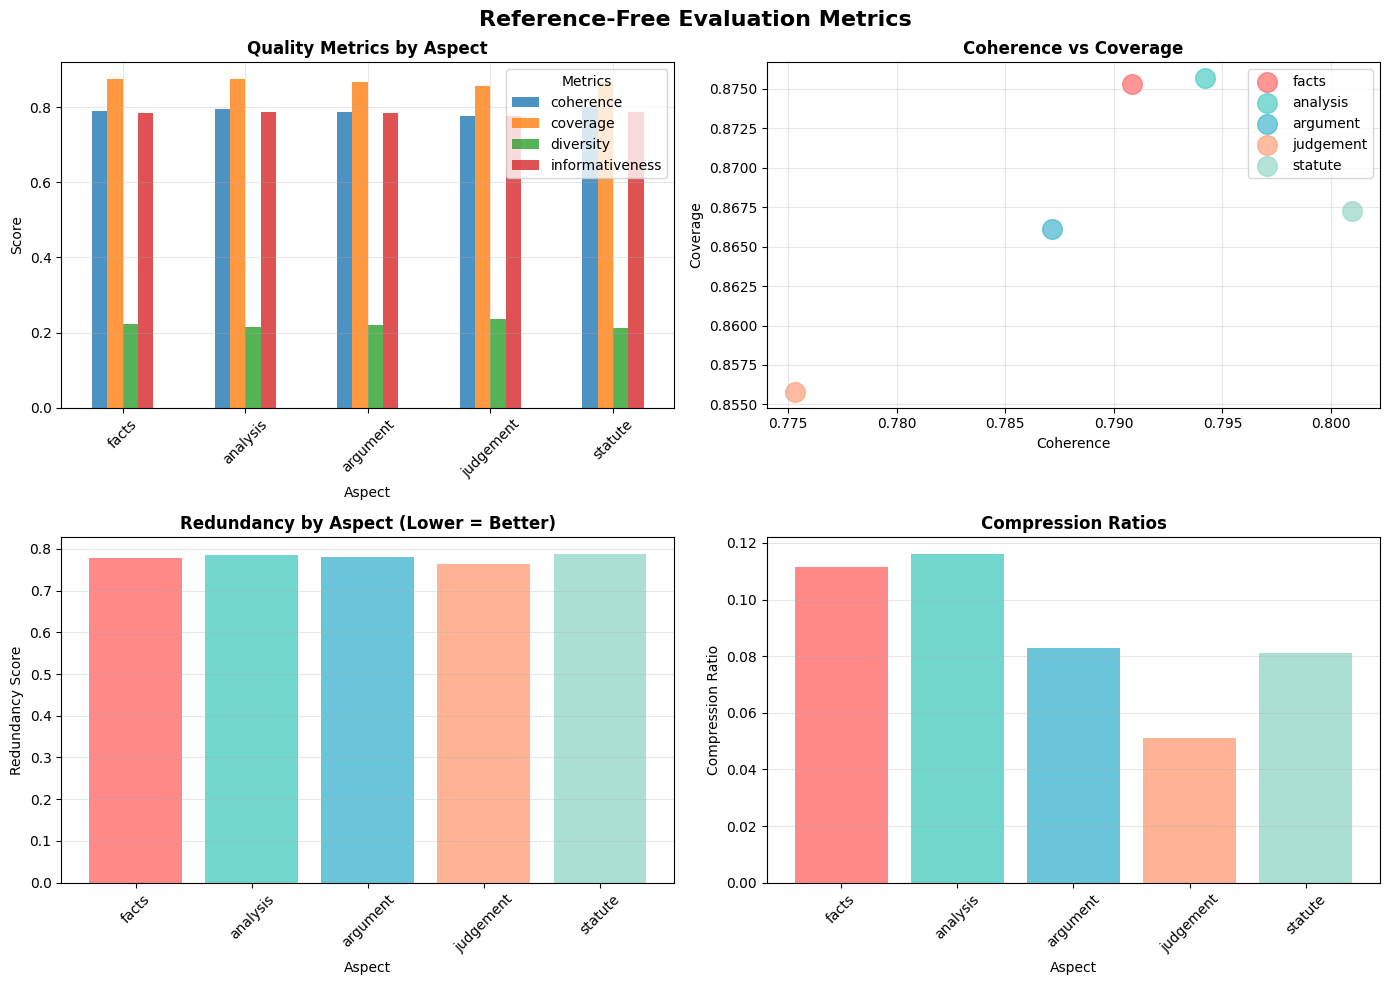

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_reference_free(rf_metrics):
    """
    Visualize reference-free metrics
    """
    aspects = agent.aspects
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
    
    # Aggregate metrics
    agg_data = {}
    for aspect in aspects:
        if rf_metrics[aspect]:
            agg_data[aspect] = {
                k: np.mean([m[k] for m in rf_metrics[aspect]])
                for k in rf_metrics[aspect][0].keys()
            }
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Reference-Free Evaluation Metrics', fontsize=16, fontweight='bold')
    
    # Plot 1: All quality metrics
    metrics_to_plot = ['coherence', 'coverage', 'diversity', 'informativeness']
    df_plot = pd.DataFrame({
        aspect: [agg_data[aspect][m] for m in metrics_to_plot]
        for aspect in aspects if aspect in agg_data
    }, index=metrics_to_plot)
    
    df_plot.T.plot(kind='bar', ax=axes[0, 0], alpha=0.8)
    axes[0, 0].set_title('Quality Metrics by Aspect', fontweight='bold')
    axes[0, 0].set_xlabel('Aspect')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].legend(title='Metrics', loc='upper right')
    axes[0, 0].set_xticklabels(aspects, rotation=45)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Coherence vs Coverage
    for idx, aspect in enumerate(aspects):
        if aspect in agg_data:
            axes[0, 1].scatter(agg_data[aspect]['coherence'], 
                             agg_data[aspect]['coverage'],
                             label=aspect, color=colors[idx], s=200, alpha=0.7)
    axes[0, 1].set_title('Coherence vs Coverage', fontweight='bold')
    axes[0, 1].set_xlabel('Coherence')
    axes[0, 1].set_ylabel('Coverage')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Redundancy (lower is better)
    redundancy_vals = [agg_data[aspect]['redundancy'] for aspect in aspects if aspect in agg_data]
    axes[1, 0].bar(aspects, redundancy_vals, color=colors, alpha=0.8)
    axes[1, 0].set_title('Redundancy by Aspect (Lower = Better)', fontweight='bold')
    axes[1, 0].set_xlabel('Aspect')
    axes[1, 0].set_ylabel('Redundancy Score')
    axes[1, 0].set_xticklabels(aspects, rotation=45)
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Plot 4: Compression ratios
    compression_vals = [agg_data[aspect]['compression_ratio'] for aspect in aspects if aspect in agg_data]
    axes[1, 1].bar(aspects, compression_vals, color=colors, alpha=0.8)
    axes[1, 1].set_title('Compression Ratios', fontweight='bold')
    axes[1, 1].set_xlabel('Aspect')
    axes[1, 1].set_ylabel('Compression Ratio')
    axes[1, 1].set_xticklabels(aspects, rotation=45)
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('reference_free_metrics.png', dpi=300, bbox_inches='tight')
    print("✅ Saved to 'reference_free_metrics.png'")
    plt.show()

visualize_reference_free(rf_metrics)
